# Where to measure the logistic curve?

This example illustrates the use of simulated data to determine how best to measure a system to estimate its parameters. It also uses parameter sensitivities to explain these results.

The differential equation:

\begin{equation}
\frac{dy}{dt} = \alpha y\left(1 - \frac{y}{\kappa}\right),
\end{equation}

has $y(0) = y_0$ as the initial condition. This system has a solution of the form:

\begin{equation}
y(t) = \frac{\kappa}{1 + \left(\frac{\kappa-y_0}{y_0}\right)\exp(-\alpha t)},
\end{equation}

which results in a logistic curve, which is used throughout mathematical biology.

We assume that the system can be measured at any discrete times between $t=0$ and $t=20$. The measurement, however, is imperfect and results in noisy observed data:

\begin{equation}
\tilde y(t) \sim \text{normal}(y(t), \sigma).
\end{equation}

Write a function to solve the logistic equation.

In [1]:
import numpy as np
import scipy
import statsmodels.api as sm
from plotnine import *
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats

In [2]:
def logistic_growth(t, alpha, kappa, y0):
    return kappa / (1 + (kappa - y0) / y0 * np.exp(-alpha * t))

Determine the sensitivitity of $y(t)$ with respect to each of $\alpha$ and $\kappa$.

The solutions are:
    
$\frac{dy}{d\alpha} = \frac{\kappa  t e^{-\alpha t} (\kappa -\text{y0})}{\text{y0} \left(\frac{e^{-\alpha t} (\kappa -\text{y0})}{\text{y0}}+1\right)^2}$

$\frac{dy}{d\kappa} = \frac{\text{y0}^2 e^{\alpha  t} \left(e^{\alpha  t}-1\right)}{\left(\kappa +\text{y0}
   \left(e^{\alpha  t}-1\right)\right)^2}$

Assuming $\alpha=1$, $\kappa=100$ and $y_0=1$, plot these sensitivities over time.

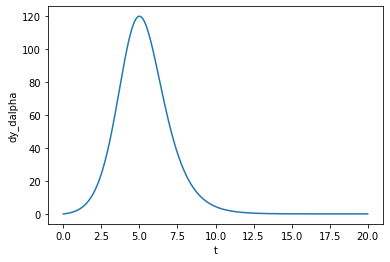

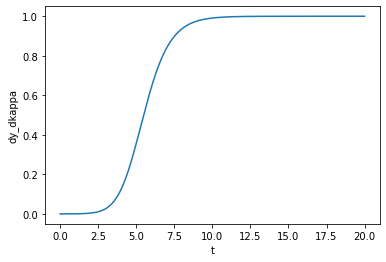

In [3]:
def sensitivity_alpha(t, alpha, kappa, y0):
    exp_alpha = np.exp(-alpha * t) * (kappa - y0)
    num = kappa * t * exp_alpha 
    denom = y0 * (exp_alpha / y0 + 1)**2
    return num / denom

def sensitivity_kappa(t, alpha, kappa, y0):
    exp_alpha1 = np.exp(alpha * t)
    num = y0**2 * exp_alpha1 * (exp_alpha1 - 1)
    denom = (kappa + y0 * (exp_alpha1 - 1))**2
    return num / denom

t = np.linspace(0, 20, 2000)
dy_da = [sensitivity_alpha(ts, 1, 100, 1) for ts in t]
plt.plot(t, dy_da)
plt.xlabel('t')
plt.ylabel('dy_dalpha')
plt.show()

dy_dk = [sensitivity_kappa(ts, 1, 100, 1) for ts in t]
plt.plot(t, dy_dk)
plt.xlabel('t')
plt.ylabel('dy_dkappa')
plt.show()

Suppose that you believed $\alpha=1$, $\kappa=100$ and $y_0=1$ were the most likely set of parameters a priori. If you were only allowed to measure the system once, approximately which $t$ value should you pick to estimate $\alpha$?

From the graph, near $t=5$ has the highest sensitivity.

Similarly, if you could only measure the system once, where should you measure it to estimate $\kappa$?

$t=20$ since this has the maximum sensitivity wrt $\kappa$.

Write a function to generate discrete measurements from the system at a series of time points.

In [4]:
def measurement(t, alpha, kappa, y0, sigma):
    y = [logistic_growth(ts, alpha, kappa, y0) for ts in t]
    eta = np.random.normal(0, sigma, len(t))
    return np.array(y) + eta

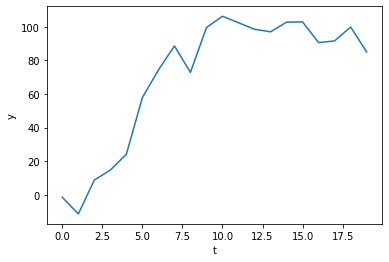

In [5]:
t = np.linspace(0, 20, 20)
y = measurement(t, 1, 100, 1, 10)
plt.plot(y)
plt.xlabel('t')
plt.ylabel('y')
plt.show()

Using Scipy's `minimize` function, write a function that calculates root-mean-square distance (rmse) between your observations and model solutions across all time points.

That is, we suppose there are errors:

\begin{equation}
error(t) = y(t) - \frac{\kappa}{1 + \left(\frac{\kappa-y_0}{y_0}\right)\exp(-\alpha t)},
\end{equation}

which result in a sum of squared errors:

\begin{equation}
sse = \sum_{t=t_1}^{t=t_T} error(t)^2,
\end{equation}

and a root-mean-square distance:

\begin{equation}
rmse = \sqrt{sse/T}.
\end{equation}

In [6]:
def rmse(y_true, t, alpha, kappa, y0):
    y_sim = [logistic_growth(ts, alpha, kappa, y0) for ts in t]
    y_diff = y_true - y_sim
    sse = y_diff**2
    return np.sqrt(np.mean(sse))

Using Scipy's `minimize` function, write a function that estimates $\alpha$ and $\kappa$ using a series of measurements assuming $y_0=1$.

In [7]:
def rmse_2d(params):
    alpha = params[0]
    kappa = params[1]
    return rmse(y, t, alpha, kappa, 1)

def optimise(y_noise, t, y_0):
    # here I start at the true values (as a bit of a cheat)
    res = scipy.optimize.minimize(rmse_2d, [1, 2])
    estimates = res['x']
    alpha = estimates[0]
    kappa = estimates[1]
    return alpha, kappa

In [8]:
optimise(y, t, 1)

(0.8973706164057993, 96.92197816704287)

Write a function which simulates measured data using known values of $\alpha$, $\kappa$ and $\sigma$ and uses this to estimate $\alpha$ and $\kappa$ assuming $y_0=1$.

In [9]:
def generate_then_optimise(t, alpha, kappa, y0, sigma):
    y_noise = measurement(t, alpha, kappa, y0, sigma)
    
    def rmse_2d(params):
        alpha = params[0]
        kappa = params[1]
        return rmse(y_noise, t, alpha, kappa, y0)
    
    def optimise(y_noise, t, y_0):
        # here I start at the true values (as a bit of a cheat)
        res = scipy.optimize.minimize(rmse_2d, [1, 100])
        estimates = res['x']
        alpha = estimates[0]
        nu = estimates[1]
        return alpha, nu
    
    return optimise(y_noise, t, y0)

In [10]:
generate_then_optimise([5, 20], 1, 100, 1, 10)

(0.9070452276951979, 115.55075365104365)

Assume $\alpha=1$, $\kappa=100$, $y_0=1$ and $\sigma=10$. Suppose that you have two measurement schemes available:

- 10 uniformly gridded measurements between $t=2$ and $t=8$.
- 10 uniformly gridded measurements between $t=15$ and $t=20$.

Using 100 replicates for each of these schemes, show that the former produces better estimates of $\alpha$. Show that the reverse is true for $\kappa$.

In [11]:
nreplicates = 100
alpha_est_5 = []
alpha_est_20 = []
kappa_est_5 = []
kappa_est_20 = []
t1 = np.linspace(2, 8, 10)
t2 = np.linspace(15, 20, 10)
alpha = 1
kappa = 100
y0 = 1
sigma = 10
for i in range(nreplicates):
    alpha_5, kappa_5 = generate_then_optimise(t1, alpha, kappa, y0, sigma)
    alpha_20, kappa_20 = generate_then_optimise(t2, alpha, kappa, y0, sigma)
    alpha_est_5.append(alpha_5)
    alpha_est_20.append(alpha_20)
    kappa_est_5.append(kappa_5)
    kappa_est_20.append(kappa_20)

/Users/appleuser/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
/Users/appleuser/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
/Users/appleuser/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp


/usr/local/lib/python3.7/site-packages/plotnine/facets/facet.py:552: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


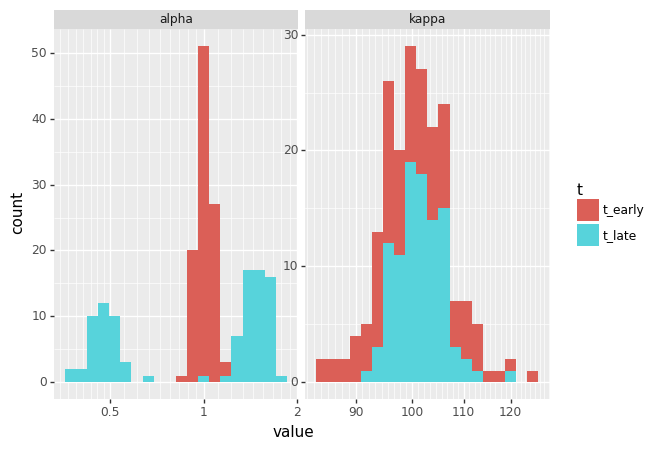

<ggplot: (348177761)>

In [14]:
df = pd.DataFrame({'alpha': alpha_est_5, 'kappa': kappa_est_5, 't': 't_early'})
df1 = pd.DataFrame({'alpha': alpha_est_20, 'kappa': kappa_est_20, 't': 't_late'})
df = pd.concat([df, df1],ignore_index=True)
df = pd.melt(df, id_vars='t')
df["t"] = df["t"].astype("category")
(ggplot(df, aes(x='value', fill='t')) +
 geom_histogram(bins=20) +
 scale_x_log10() +
 facet_wrap('variable', scales="free"))